A/B experiment evaluation using the standard tests

Hypothesis. ML team advised that the recommendations are making posts more interesting. Our ML team has created two new predicitive models on suggesting what posts the user might like. The first model is based on the posts user liked in the past and the second model is based on the posted that users similar to our user liked. We are checking the second model - recommendations are based on the posted that users similar to our user liked. We will use the CTR metric to decide if the new system should be deployed to production or not.

In [18]:
# Importing the libraries
import pandahouse as ph
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import mannwhitneyu
%matplotlib inline

In [19]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses' ,
    'password' : 'dpo_python_2020',
    'user' : 'student' ,
    'database' : 'simulator_20220720'
    }

Extracting the data from DB: control group - group1, test group - group 2

In [20]:
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) >= '2022-06-13' and toDate(time) <= '2022-06-19'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""

In [21]:
df = ph.read_clickhouse(q, connection=connection)

In [22]:
df.groupby('exp_group')['user_id'].count()

exp_group
1    10079
2     9952
Name: user_id, dtype: int64

Сравним графики распределений CTR визуально

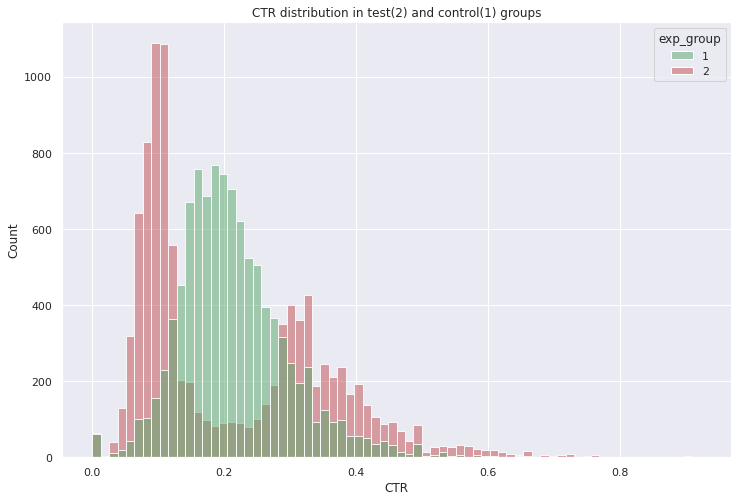

In [23]:
sns.set(rc={'figure.figsize':(12,8)})
groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['g', 'r'],
              alpha=0.5,
              kde=False)
plt.title('CTR distribution in test(2) and control(1) groups')
plt.xlabel('CTR')
plt.show()

По графикам видно, что метрика ухудшилась в группе 2, CTR стал меньше, чем в контрольной группе. Сравним группы статистическими тестами.

t-тест Стьюдента

In [24]:
stats.ttest_ind(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr,
                equal_var=False)

Ttest_indResult(statistic=0.7094392041270485, pvalue=0.4780623130874935)

При t-тесте Стьюдента p-value больше 0.05, соответственно, различия между средними значениями не являются статистически значимыми. Тест Стьюдента говорит, что группы похожи, но результат этого теста некорректный, так как условием для теста Стьюдента является нормальное распределение для обеих групп, но распределение группы 2 не нормальное. Проверим еще одним тестом.

Критерий Манна-Уитни

In [25]:
print(stats.mannwhitneyu(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr))

print('Отличие не прокрасилось')
                   
A_gt_B = 0
for _ in range(10000):
    A_gt_B+= df[df.exp_group == 1].ctr.sample().values[0] > df[df.exp_group == 2].ctr.sample().values[0]
    
print('В', A_gt_B/100, '% случаев A > B. Должно получиться около 50%')

MannwhitneyuResult(statistic=56601260.5, pvalue=6.0376484617779035e-56)
Отличие не прокрасилось
В 56.91 % случаев A > B. Должно получиться около 50%


Проверим еще одним тестом.

Непараметрический бутстреп

In [26]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

In [27]:
df = ph.read_clickhouse(q, connection=connection)

In [28]:
likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

In [29]:
ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

Построим диаграмму распределения полученных групповых CTR

<AxesSubplot:ylabel='Count'>

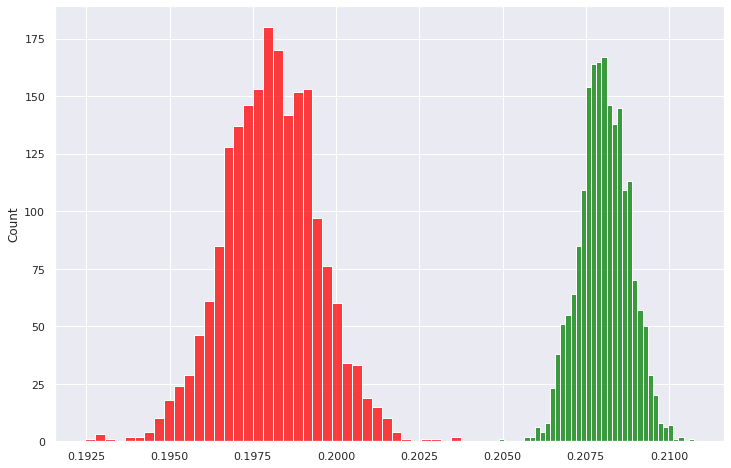

In [31]:
sns.histplot(data=ctr1, color='green')
sns.histplot(data=ctr2, color='red')

Построим график разницы групповых CTR

<AxesSubplot:ylabel='Count'>

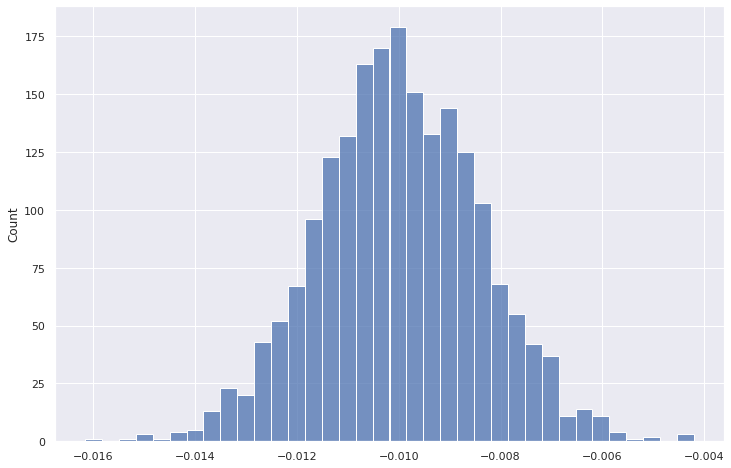

In [32]:
sns.histplot(ctr2 - ctr1)

Значения разницы групповых CTR получились меньше 0, потому что в экспериментальной группе CTR получился меньше CTR контрольной группы.

Выгрузим из БД данные для тех пользователей из тестовой и экспериментальной группы, у которых CTR получился больше 0,5.

In [33]:
q1 = """
(SELECT * 
FROM
(SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) >= '2022-06-13' and toDate(time) <= '2022-06-19'
    and exp_group in (1,2)
GROUP BY exp_group, user_id)
WHERE ctr>0.5
GROUP BY exp_group, user_id,likes, views, ctr)
"""

In [34]:
df = ph.read_clickhouse(q, connection=connection)

In [35]:
df.groupby('exp_group')['user_id'].count()

exp_group
1    10079
2     9952
Name: user_id, dtype: int64

Вывод.
Эксперимент показал, что новая система рекомендаций работает хуже, чем та система рекомендаций, которая используется на данный момент, так как значения CTR в тестовой группе оказались в среднем ниже. Не рекомендуется раскатывать новый алгортим рекомендаций на всех пользователей, так как это может привести к оттоку аудитории.
Алгоритм рекомендаций, который мы проверяли, заключался в том, что пользователям показывали посты, которые лайкали похожие на него пользователи. Возможно ошибка алгоритма заключалась в том, что "похожесть" пользователей была посчитана некорректно, имеет смысл изменить параметры "похожести" и провести еще один эксперимент. 
Была замечена интересная деталь - в тестовой группе CTR был в среднем меньше, чем в контрольной группе, при этом количество пользователей, у которых CTR был выше 0,5, в тестовой группе оказался выше. У 61 пользователя из контрольной группы CTR был выше 0,5, в тествой группе CTR выше 0,5 был выше у 309 пользователей. Это говорит о том, что для этой группы пользователей новый алгоритм рекомендаций работает лучше, нужно посмотреть на эту группу и понять, какие общие характеристики позволили новому алгоритму рекомендаций правильно определить "похожесть".